In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import importlib, numpy as np
from sys import path

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from ndcube import NDCube, NDCubeSequence, NDCollection
from astropy import wcs

import astropy.units as u
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # Make the fonts in figures big enough for papers
plt.rcParams.update({'figure.figsize':[27,15]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=128)

base_path = "../"
emtk_path = base_path+'code/'
path.append(emtk_path)

#import EMToolKit
#importlib.reload(EMToolKit.visualization.dashboard)

import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_figure
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.algorithms.sparse_em_wrapper import sparse_em_wrapper
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper

/tmp/ipykernel_4734/4025610558.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


/home/hafarooki/research/EMToolKit/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
xlen = 512*0.6*u.arcsec # 125*u.arcsec # X size of FOV in arcseconds
ylen = 512*0.6*u.arcsec # 175*u.arcsec # Y size of FOV in arcseconds
xl = -300*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
yl = -425*u.arcsec # Right edge of FOV in arcseconds (relative to disk center)

xlen = 400*0.6*u.arcsec # 125*u.arcsec # X size of FOV in arcseconds
ylen = 400*0.6*u.arcsec # 175*u.arcsec # Y size of FOV in arcseconds
xl = -0*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
yl = -0*u.arcsec # Right edge of FOV in arcseconds (relative to disk center)

sdo_data_dir = base_path+"data/20120711/" # Place to put data files. You'll need to change it or create these subdirectories
# Example data to load. We'll use a part of the field of view observed by the Hi-C rocket in 2012.
date='2012/07/11 18:54:00' 

# Commands for initial data download. Comment out once that's successful.
# VSO can sometimes be a bit flakey here, in my experience, may require multiple tries:
# paths = []
# passbands = np.array([94,131,171,193,211,335])*u.angstrom
# for band in passbands: 
#    qry = Fido.search(a.Time(TimeRange(date,12*u.s)),a.Instrument('AIA'),a.Wavelength(band))[0,0]
#    paths.append(Fido.fetch(qry,path=sdo_data_dir, site="ROB"))

# Manually entered paths for after initial data download, may need to be edited.
paths = ['aia_20120711_185401_0094_image_lev1.fits',
         'aia_20120711_185402_0335_image_lev1.fits',
         'aia_20120711_185406_0193_image_lev1.fits',
         'aia_20120711_185408_0131_image_lev1.fits',
         'aia_20120711_185411_0171_image_lev1.fits',
         'aia_20120711_185411_0211_image_lev1.fits']
for i in range(0,len(paths)): paths[i] = sdo_data_dir + paths[i]

In [4]:
maps = load_from_paths(paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
[maps,errs,trlogts,tresps] = aia_wrapper(maps)

[Text(0.5, 1.0, 'AIA 94 Temperature Response'),
 Text(0.5, 0, 'Temperature (dB Kelvin)'),
 Text(0, 0.5, 'Response (DN/s/(cm$^{-3})^2$/Mm)')]

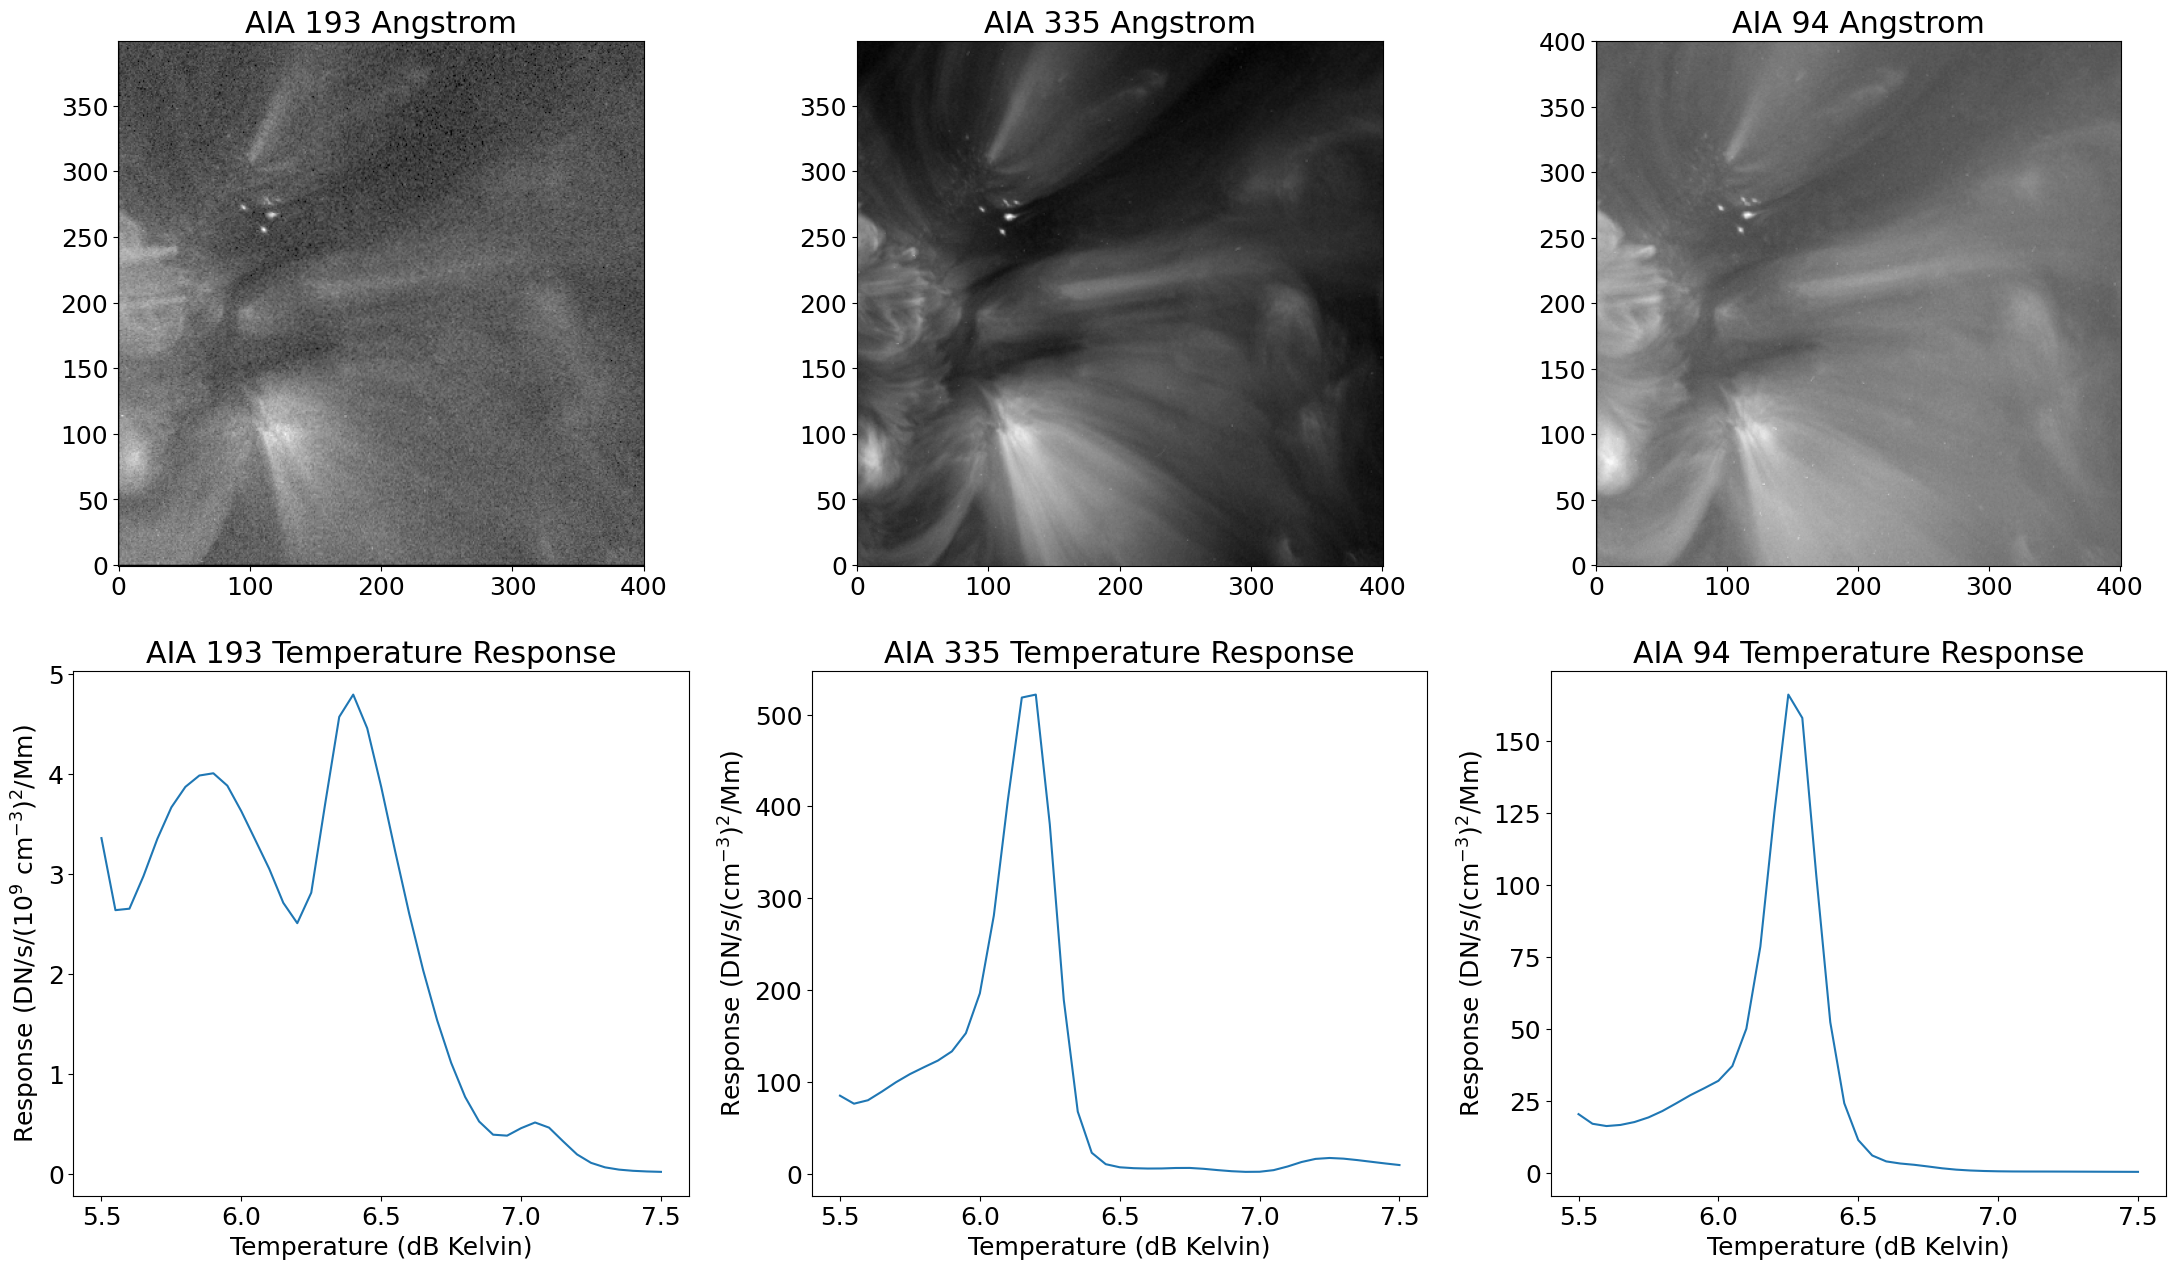

In [5]:
# Show some of the AIA channels and their temperature responses for illustration:
plt_emmax = 5.0e28
gfac = 1.0/2.2

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(np.clip(maps[1].data/np.max(tresps[1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,0].set(title='AIA 193 Angstrom')
axs[1,0].plot(trlogts[1],tresps[1]/1.0e-27)
axs[1,0].set(title='AIA 193 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

axs[0,1].imshow(np.clip(maps[2].data/np.max(tresps[2]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,1].set(title='AIA 335 Angstrom')
axs[1,1].plot(trlogts[2],tresps[2]/1.0e-27)
axs[1,1].set(title='AIA 335 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

axs[0,2].imshow(np.clip(maps[5].data/np.max(tresps[5]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,2].set(title='AIA 94 Angstrom')
axs[1,2].plot(trlogts[5],tresps[5]/1.0e-27)
axs[1,2].set(title='AIA 94 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

In [6]:
# Make data sequence from AIA data:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with AIA data:
em_collection = emtk.em_collection(datasequence)

In [21]:
# Compute the DEM for Plowman & Caspi simple_reg_dem method:
simpl_coeffs, simpl_logts, simpl_bases, simpl_coords, simpl_algorithm = simple_reg_dem_wrapper(datasequence, cuda=True)
# Make DEM sequence from the DEM and add it to the collection:
simple_reg_demsequence = emtk.dem_model(simpl_coeffs, simpl_logts, simpl_bases, simpl_coords, simpl_algorithm, simple_reg_dem_wrapper)
em_collection.add_model(simple_reg_demsequence)

In [22]:
simpl_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=simpl_algorithm)

In [24]:
def calc_resids(synthdata, em_collection):# Calculate the residuals and Chi squared:
    ndata = len(synthdata)
    resids = []
    datasequence = em_collection.data()
    chi2 = 0
    [nx,ny] = datasequence[0].data.shape
    for seq in datasequence: [nx,ny] = [np.min([seq.data.shape[0],nx]),np.min([seq.data.shape[1],ny])]
    for i in range(0,ndata):
        exptime = datasequence[i].meta['exptime']
        nx = np.min([synthdata[i].data.shape[0],datasequence[i].data.shape[0],datasequence[i].uncertainty.array.shape[0]])
        ny = np.min([synthdata[i].data.shape[1],datasequence[i].data.shape[1],datasequence[i].uncertainty.array.shape[1]])
        resids.append(((exptime*synthdata[i].data[0:nx,0:ny]-datasequence[i].data[0:nx,0:ny])/datasequence[i].uncertainty.array[0:nx,0:ny])**2)
        chi2 += np.mean(resids)/ndata        
    return resids, chi2

simpl_resids, simpl_chi2 = calc_resids(simpl_synthdata,em_collection)
print('simple_reg_dem Chi squared = ',simpl_chi2)

simple_reg_dem Chi squared =  1.3796968642320275


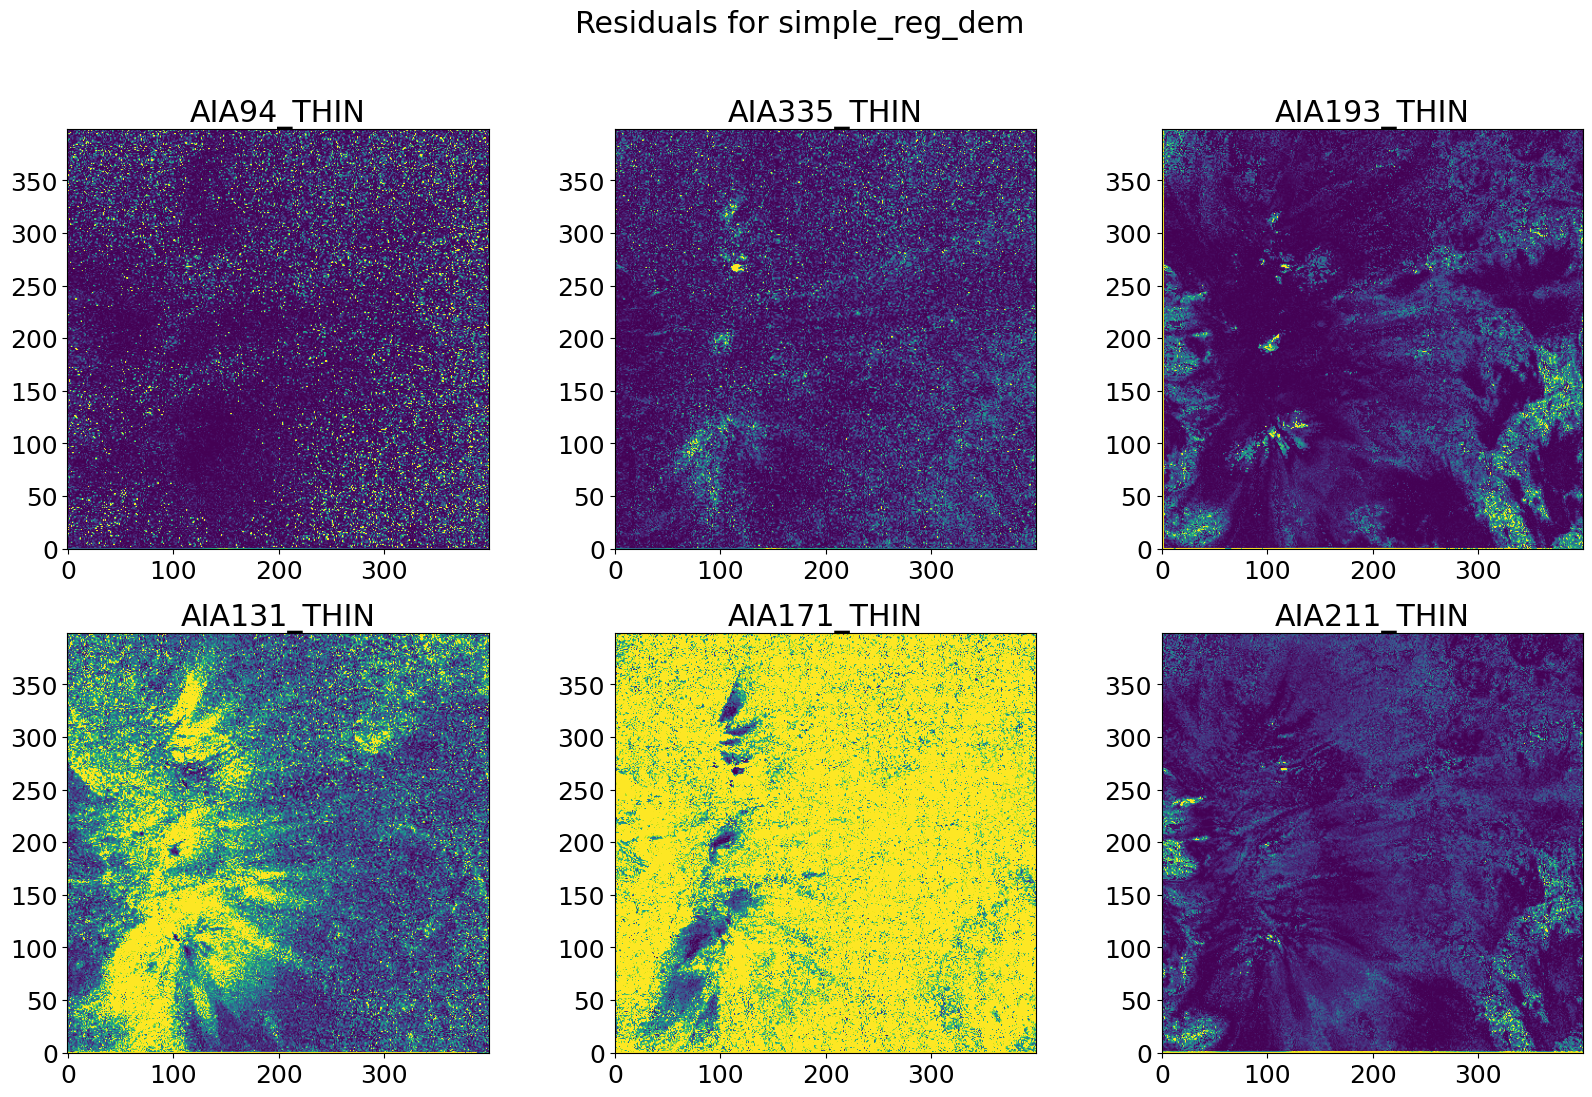

In [25]:
# Plot Residuals:
fig = plt.figure(figsize=[20,12])
plt.suptitle('Residuals for '+simpl_algorithm)
for i in range(0,6):
    ax1 = fig.add_subplot(2,3,i+1)
    ax1.imshow(simpl_resids[i],vmin=0,vmax=5)
    ax1.set(title=em_collection.data()[i].meta['channel'])

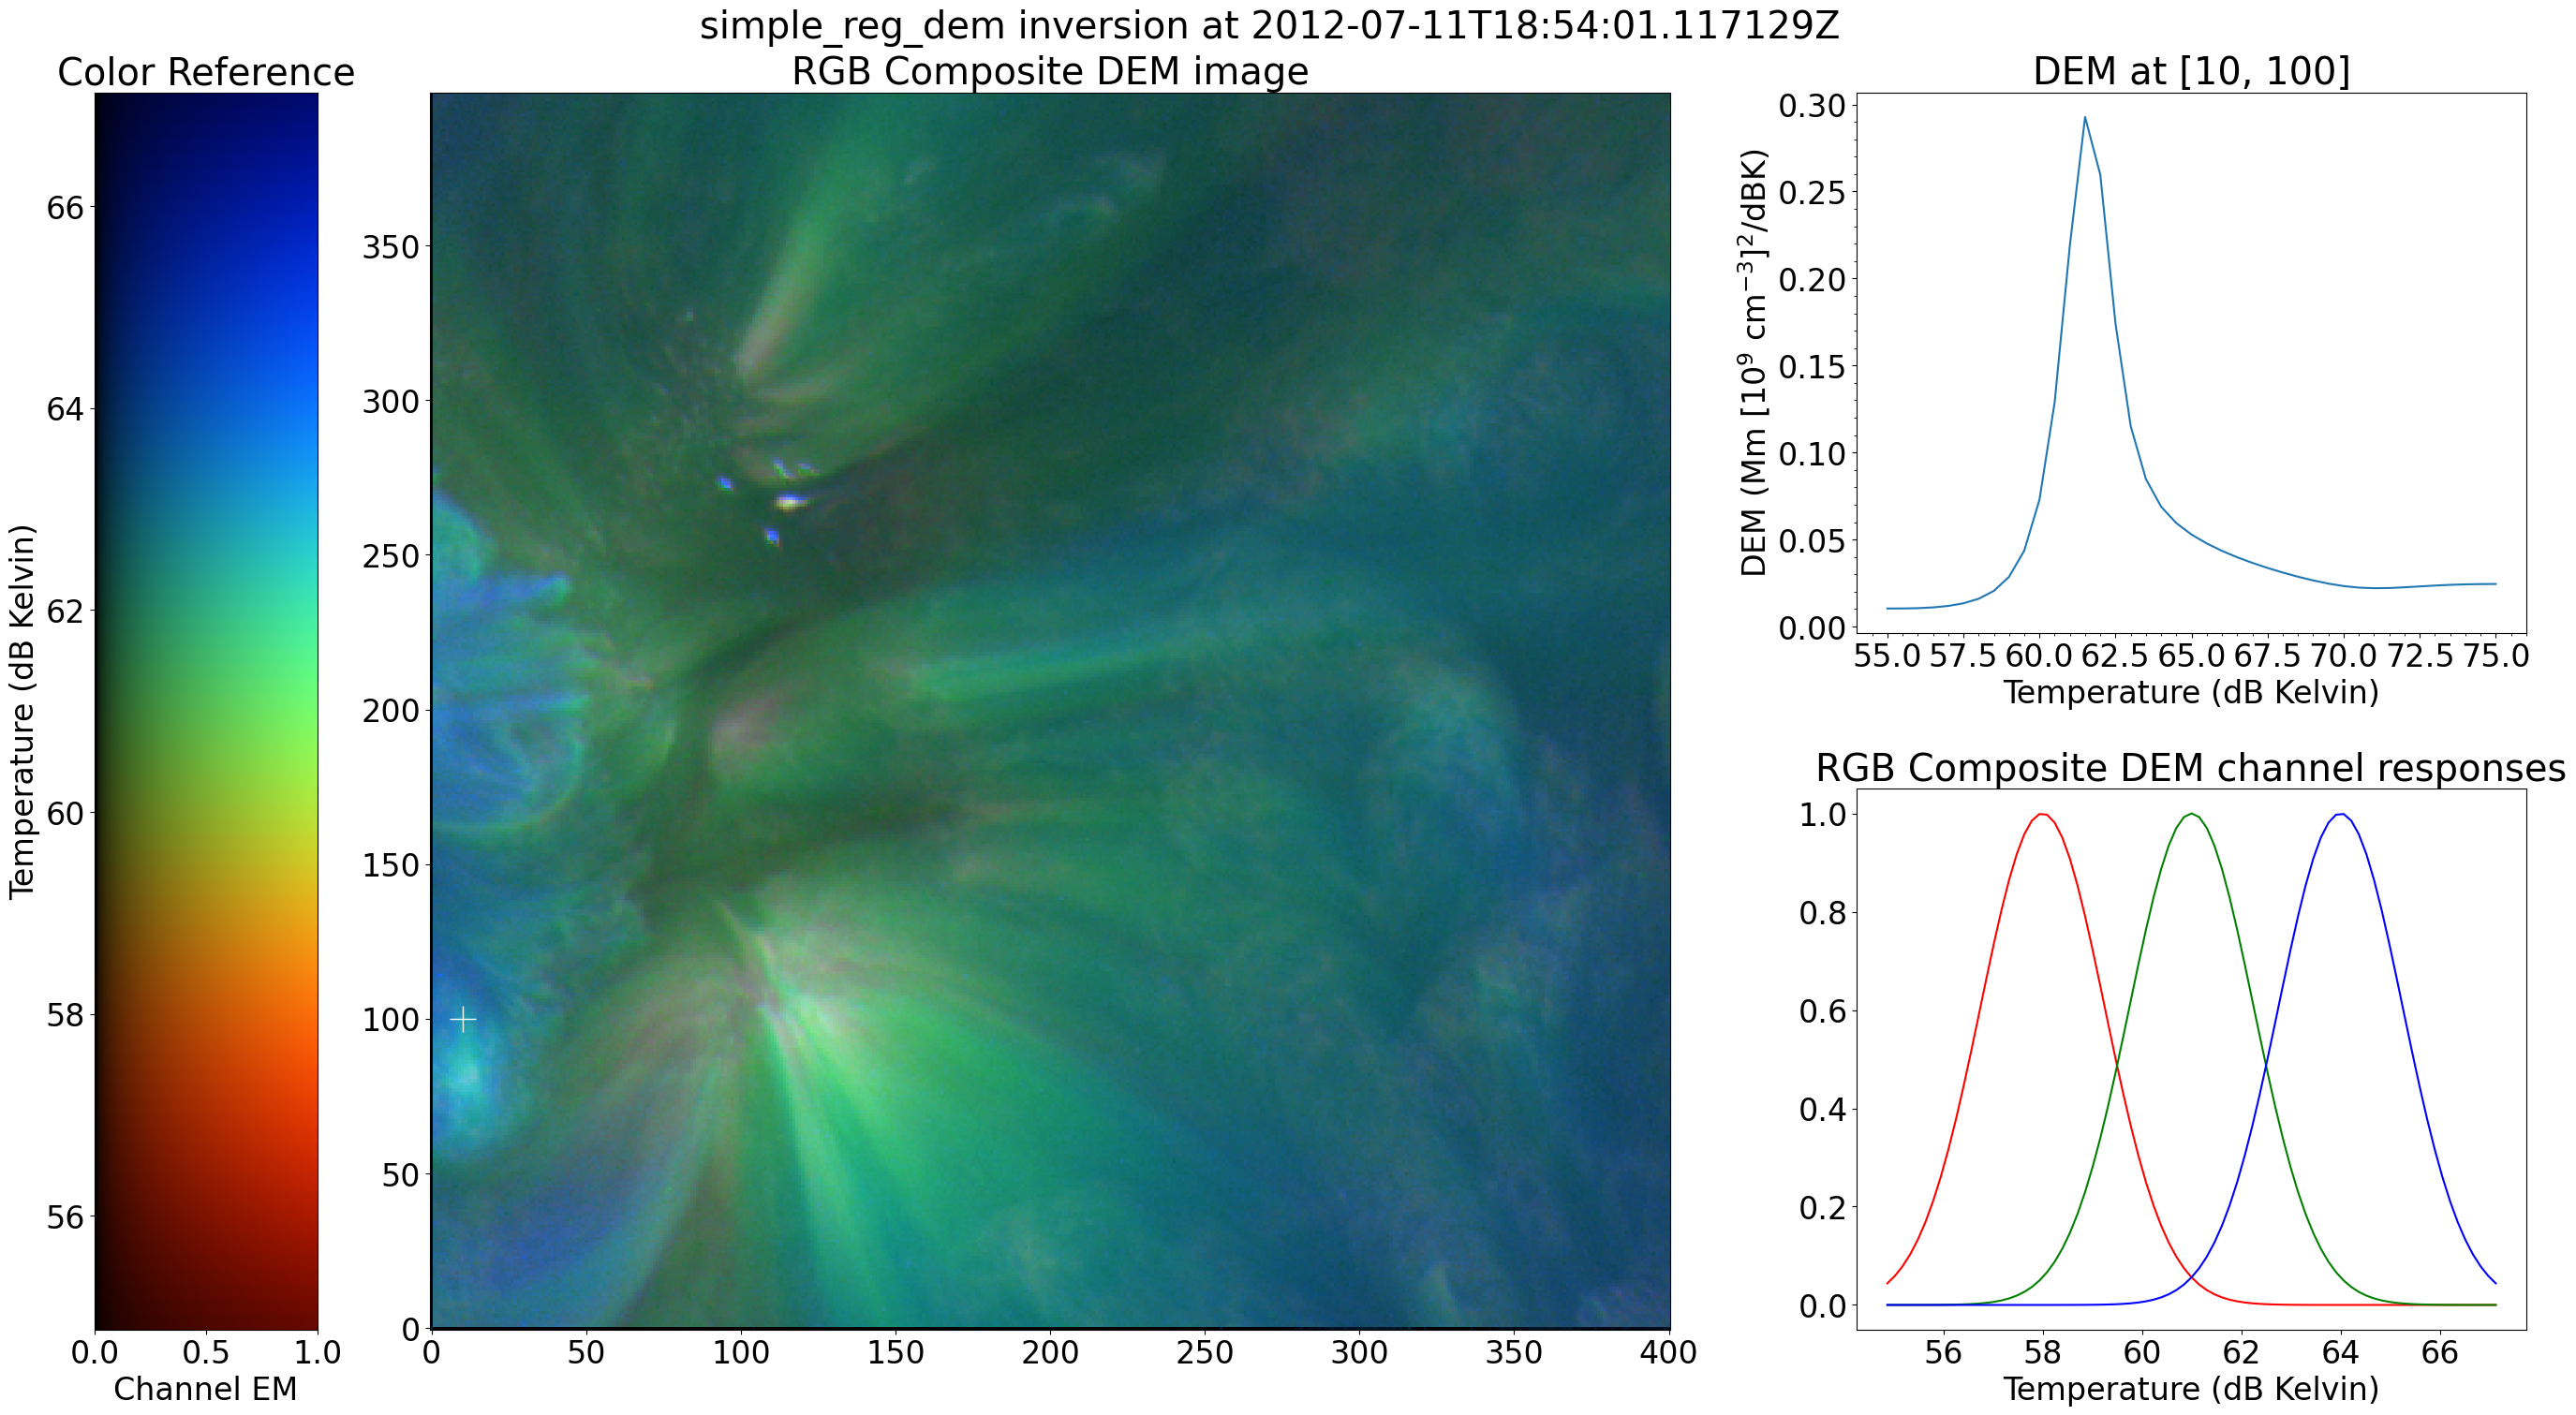

In [26]:
dashboard_figure(em_collection, plotpoint=[10,100], temperatures=[5.8,6.1,6.4], sigmas=0.125, algorithm=simpl_algorithm)

In [ ]:
# Compute the DEM for Cheung et al. sparse EM method:
spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm = sparse_em_wrapper(datasequence, gpu=True)
# Make DEM sequence from the DEM and add it to the collection:
sparse_em_demsequence = emtk.dem_model(spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm, sparse_em_wrapper)
em_collection.add_model(sparse_em_demsequence)

In [16]:
spars_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=spars_algorithm)

spars_resids, spars_chi2 = calc_resids(spars_synthdata,em_collection)
simpl_resids, simpl_chi2 = calc_resids(simpl_synthdata,em_collection)
print('simple_reg_dem Chi squared = ',simpl_chi2, 'spars_em Chi squared = ',spars_chi2)

NameError: name 'spars_algorithm' is not defined

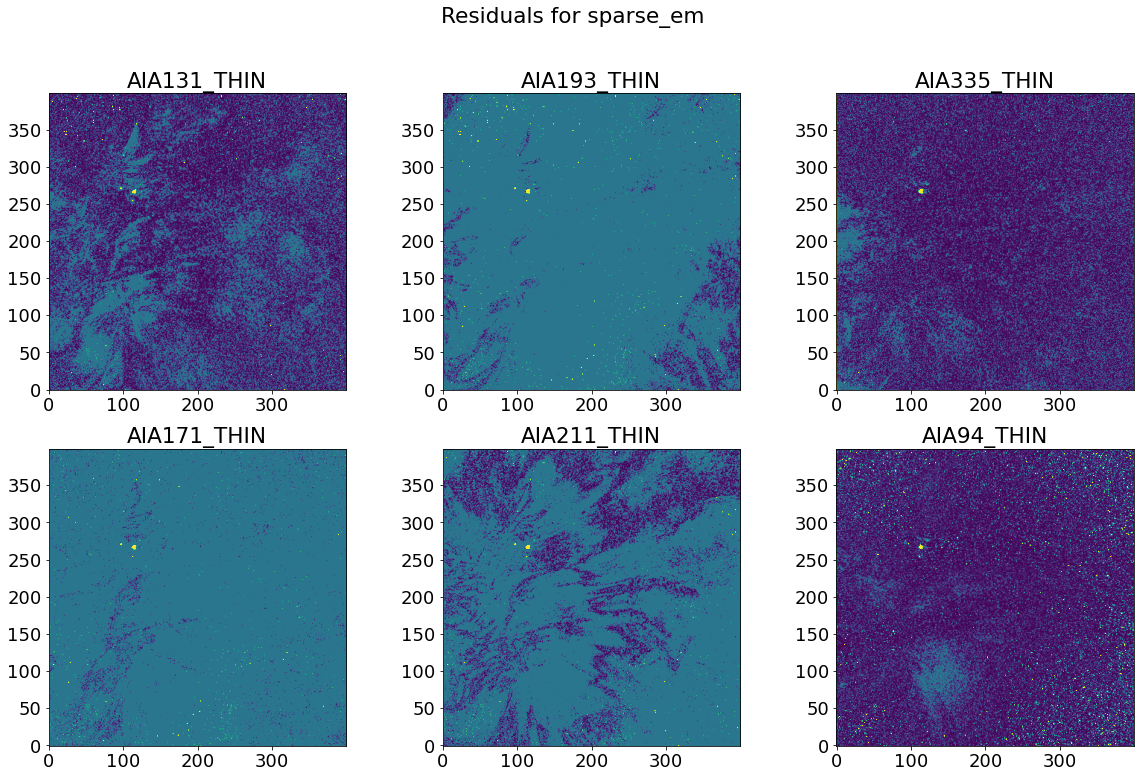

In [ ]:
# Plot Residuals:
fig = plt.figure(figsize=[20,12])
plt.suptitle('Residuals for '+spars_algorithm)
for i in range(0,6):
    ax1 = fig.add_subplot(2,3,i+1)
    ax1.imshow(spars_resids[i],vmin=0,vmax=5)
    ax1.set(title=em_collection.data()[i].meta['channel'])

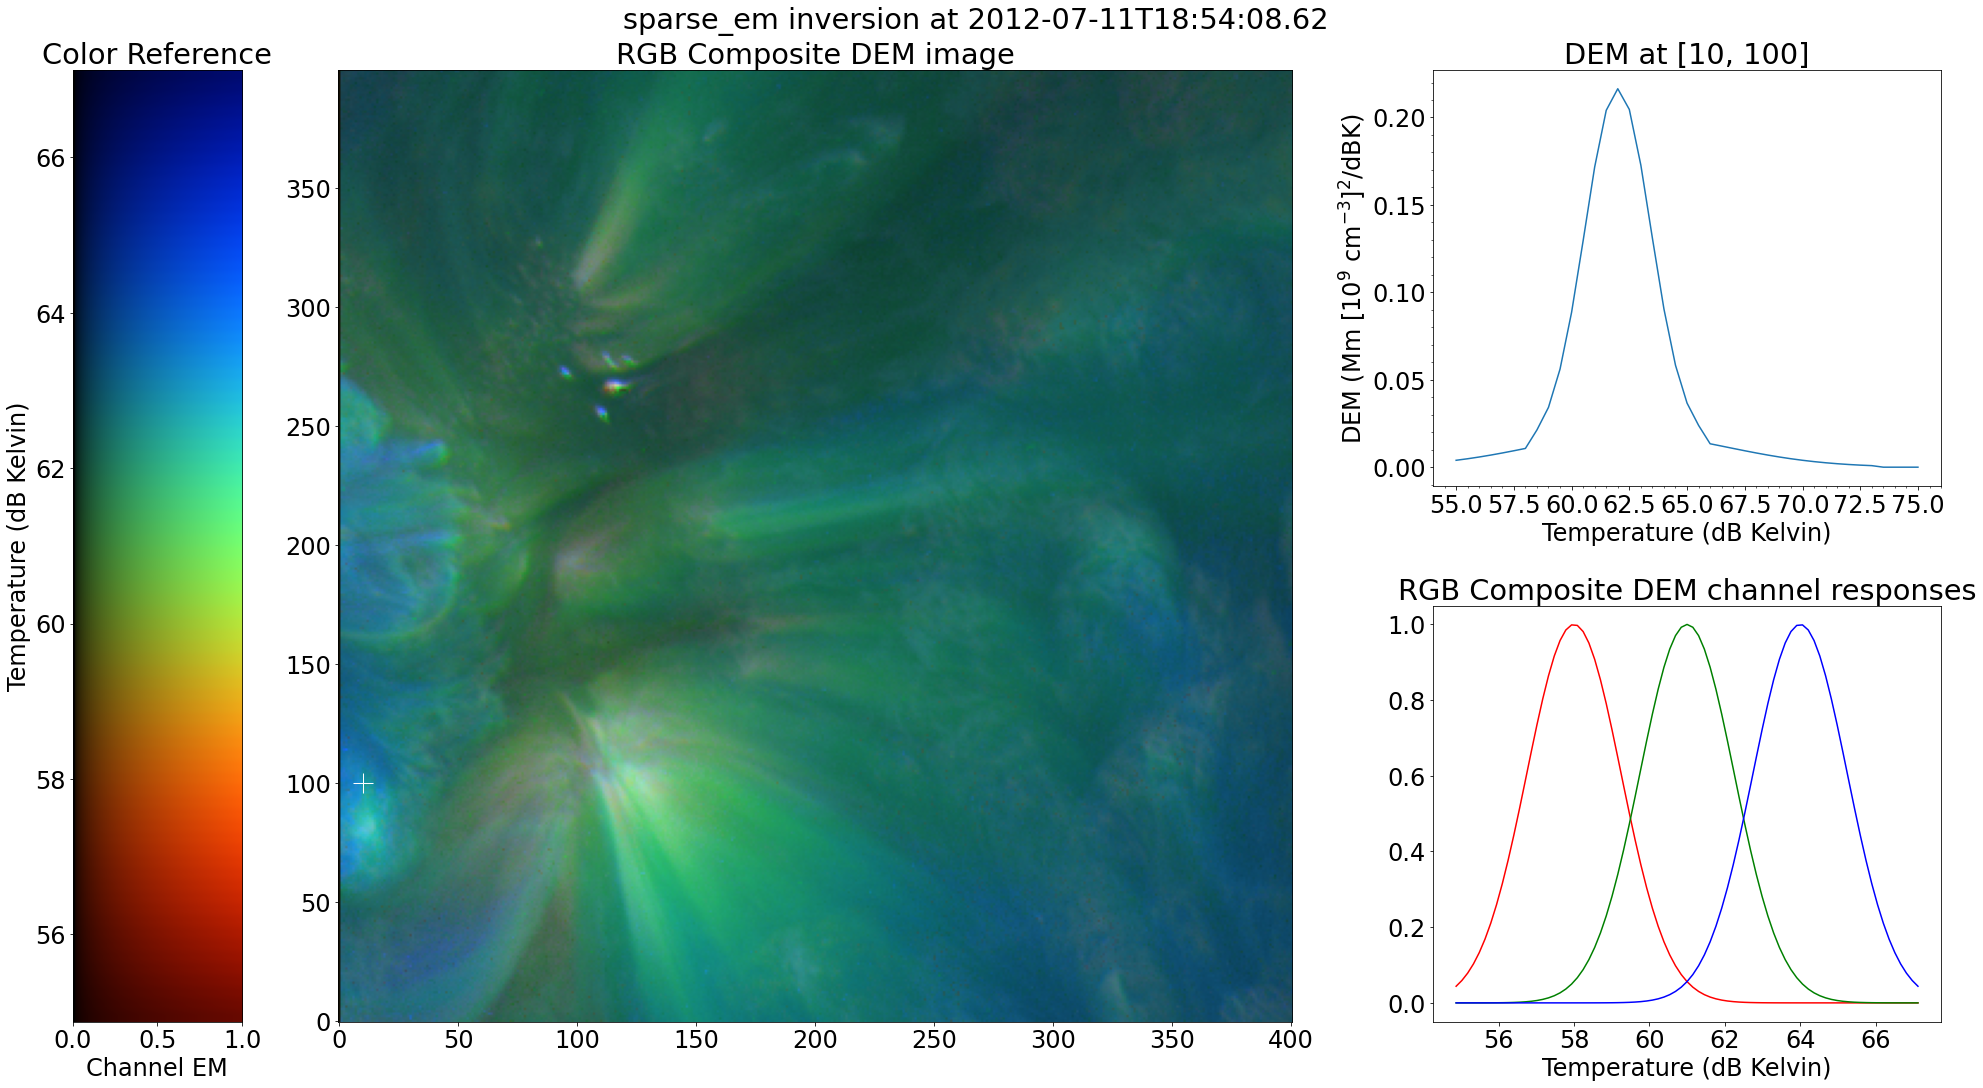

In [ ]:
dashboard_figure(em_collection, plotpoint=[10,100], temperatures=[5.8,6.1,6.4], sigmas=0.125, algorithm=spars_algorithm)